In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


In [ ]:
!pip install opendatasets --upgrade --quiet
import urllib.request
import opendatasets as od

od.download("https://www.kaggle.com/datasets/rosaliepampolina/aps360-augmented-yoga-poses-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: georgezwangnottaken 
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rosaliepampolina/aps360-augmented-yoga-poses-dataset


100%|██████████| 2.06G/2.06G [00:30<00:00, 72.5MB/s]


In [ ]:
# Define the path to your dataset
data_dir = '/content/aps360-augmented-yoga-poses-dataset/augmented_dataset'
#careful

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [ ]:
# Define the split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

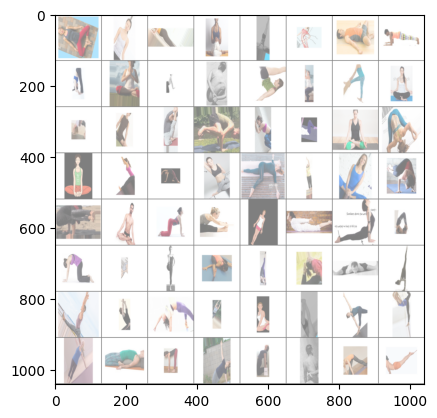

Bound Angle Pose Easy Pose Four-Limbed Staff Pose Cow Face Pose Supported Shoulderstand Half Frog Pose Reclining Bound Angle Pose Dolphin Plank Pose Big Toe Pose Lotus Pose Cat Pose Noose Pose Plow Pose Eagle Pose Intense Side Stretch Pose Easy Pose Upward Bow Pose Bharadvajas Twist Heron Pose Side Crane Pose Eagle Pose Supine Spinal Twist Lotus Pose Wide-Legged Forward Bend Bound Angle Pose Staff Pose Wild Thing Cow Face Pose Supine Spinal Twist Upward salute Bound Angle Pose Side Crane Pose Side Crane Pose Lotus Pose Cow Pose Seated Forward Bend Mountain Pose Crocodile Pose Upward Facing Dog Formidable Face Pose Cat Pose Hero Pose Extended Hand to Big Toe Pose Tortoise Pose Standing Split Bow Pose Tortoise Pose Standing Split Monkey Pose Heron Pose Wild Thing Chair Pose Bharadvajas Twist Heron Pose Revolved Triangle Pose Lord of the Dance Pose Side Plank Pose Reclining Hero Pose Standing Half Forward Bend Side Plank Pose Camel Pose Bharadvajas Twist Intense Side Stretch Pose Cobra Po

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, len(dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
!nvidia-smi

Wed Aug  7 01:27:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              34W /  70W |   1421MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def get_accuracy(model, dataloader):
  "Gets accuracy for final accuracy and accuracy plots"
  correct=0
  total=0
  with torch.no_grad():
    for imgs, labels in dataloader:

      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          # print("consist")
          imgs = imgs.cuda()
          labels = labels.cuda()

      outputs = model(imgs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      # print(predicted)#weird size mismatch
      # print(labels)

      correct += (predicted == labels).sum().item()#adds sum of them
  return correct/total

### training with plots


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def get_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

def train_plot(model, train_loader, val_loader, num_epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, valid_acc = [], [], [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Record statistics after each epoch
        iters.append(epoch + 1)
        losses.append(running_loss / len(train_loader))
        train_acc.append(get_accuracy(model, train_loader, device))
        valid_acc.append(get_accuracy(model, val_loader, device))

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')
        print(f'Train Accuracy: {train_acc[-1]:.3f}, Validation Accuracy: {valid_acc[-1]:.3f}')
        print(f'Time Elapsed: {time.time() - start_time:.2f} s')

    # Plotting loss and accuracy curves
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, valid_acc, label="Validation")
    plt.plot(iters, train_acc, label="Training")
    plt.legend(loc='best')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print("Final Training Accuracy: {:.3f}".format(train_acc[-1]))
    print("Final Validation Accuracy: {:.3f}".format(valid_acc[-1]))

# Example usage:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# train_plot(model, train_loader, val_loader, num_epochs=25, learning_rate=0.001, device=device)


WTF does "Device" code do??????????????

Epoch 1, Loss: 4.160
Train Accuracy: 0.136, Validation Accuracy: 0.110
Time Elapsed: 249.26 s
Epoch 2, Loss: 3.300
Train Accuracy: 0.261, Validation Accuracy: 0.166
Time Elapsed: 487.85 s
Epoch 3, Loss: 2.692
Train Accuracy: 0.468, Validation Accuracy: 0.221
Time Elapsed: 725.40 s
Epoch 4, Loss: 1.950
Train Accuracy: 0.667, Validation Accuracy: 0.255
Time Elapsed: 961.42 s
Epoch 5, Loss: 1.184
Train Accuracy: 0.853, Validation Accuracy: 0.260
Time Elapsed: 1197.67 s


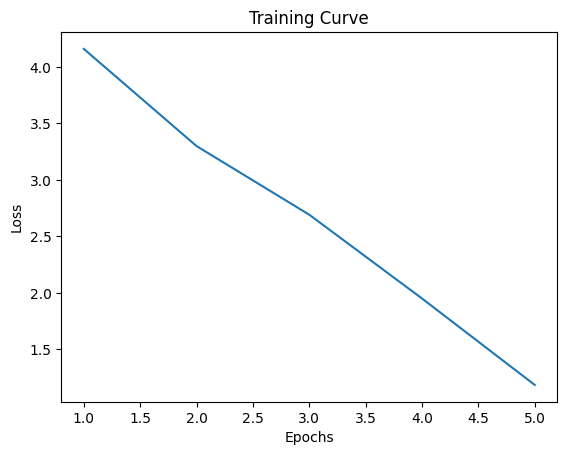

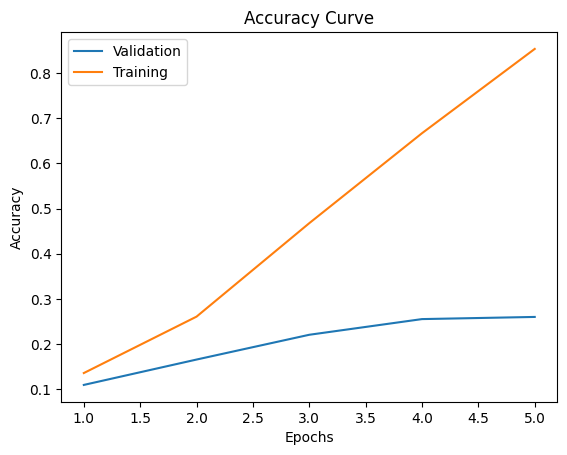

Final Training Accuracy: 0.853
Final Validation Accuracy: 0.260


In [ ]:
model = SimpleCNN()

use_cuda = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_plot(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001, device=device)

#BAtch size is 64

# train_plot(model, num_epochs=1, learning_rate=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#device it
test_acc=get_accuracy(model, test_loader,device)
print(f'Final Test Accuracy: {100 * test_acc:.2f}%')

Final Test Accuracy: 28.10%


# Tuning Hyperparameters

# Tuning Number of Epochs

Num_epochs: 10

CUDA is available!  Training on GPU ...
Epoch 1, Minibatch 100, Loss: 4.060
	Time Elapsed:  134.84 s 
Epoch 1, Minibatch 200, Loss: 3.581
	Time Elapsed:  259.58 s 
Epoch 2, Minibatch 100, Loss: 2.974
	Time Elapsed:  386.75 s 
Epoch 2, Minibatch 200, Loss: 2.948
	Time Elapsed:  512.15 s 
Epoch 3, Minibatch 100, Loss: 1.947
	Time Elapsed:  651.06 s 
Epoch 3, Minibatch 200, Loss: 2.015
	Time Elapsed:  789.43 s 
Epoch 4, Minibatch 100, Loss: 0.979
	Time Elapsed:  923.92 s 
Epoch 4, Minibatch 200, Loss: 1.052
	Time Elapsed:  1053.89 s 
Epoch 5, Minibatch 100, Loss: 0.581
	Time Elapsed:  1184.40 s 
Epoch 5, Minibatch 200, Loss: 0.577
	Time Elapsed:  1310.97 s 
Epoch 6, Minibatch 100, Loss: 0.469
	Time Elapsed:  1437.77 s 
Epoch 6, Minibatch 200, Loss: 0.490
	Time Elapsed:  1577.08 s 
Epoch 7, Minibatch 100, Loss: 0.455
	Time Elapsed:  1708.47 s 
Epoch 7, Minibatch 200, Loss: 0.451
	Time Elapsed:  1832.88 s 
Epoch 8, Minibatch 100, Loss: 0.452
	Time Elapsed:  1959.45 s 
Epoch 8, Minibatch 200

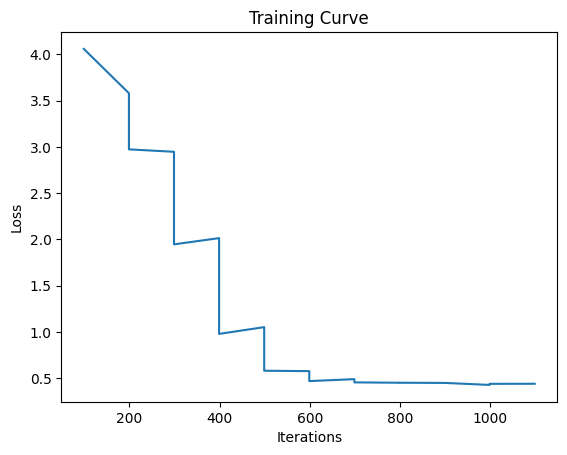

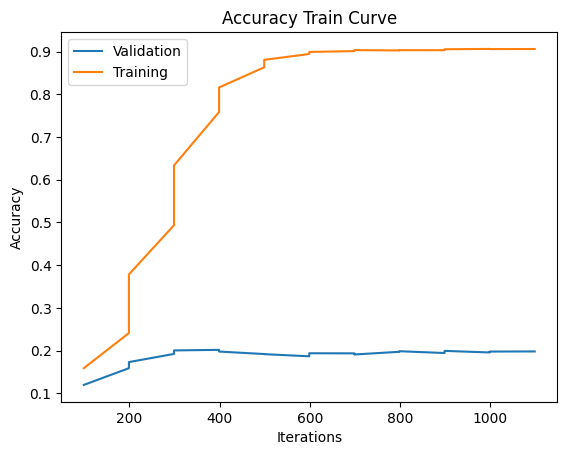

Final Training Accuracy: 0.9059072687391272
Final Validation Accuracy: 0.19804077310034418


In [ ]:
modelepoch = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  modelepoch.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(modelepoch, num_epochs=10, learning_rate=0.001)

In [ ]:
test_acc=get_accuracy(modelepoch, test_loader)
print(f'Final Test Accuracy: {100 * test_acc:.2f}%')

Final Test Accuracy: 18.25%


Num_epochs: 5

CUDA is available!  Training on GPU ...
Epoch 1, Minibatch 100, Loss: 4.005
	Time Elapsed:  125.81 s 
Epoch 1, Minibatch 200, Loss: 3.589
	Time Elapsed:  249.80 s 
Epoch 2, Minibatch 100, Loss: 2.900
	Time Elapsed:  376.19 s 
Epoch 2, Minibatch 200, Loss: 2.820
	Time Elapsed:  500.46 s 
Epoch 3, Minibatch 100, Loss: 1.648
	Time Elapsed:  627.01 s 
Epoch 3, Minibatch 200, Loss: 1.739
	Time Elapsed:  752.21 s 
Epoch 4, Minibatch 100, Loss: 0.773
	Time Elapsed:  883.45 s 
Epoch 4, Minibatch 200, Loss: 0.793
	Time Elapsed:  1007.54 s 
Epoch 5, Minibatch 100, Loss: 0.507
	Time Elapsed:  1135.19 s 
Epoch 5, Minibatch 200, Loss: 0.504
	Time Elapsed:  1259.26 s 
[99, 199, 199, 299, 299, 399, 399, 499, 499, 599]
[4.005313959121704, 3.58904577255249, 2.8996743607521056, 2.8202905869483947, 1.6476190423965453, 1.7394180345535277, 0.7733502748608589, 0.7928608763217926, 0.5070245970785617, 0.5043951414525509]


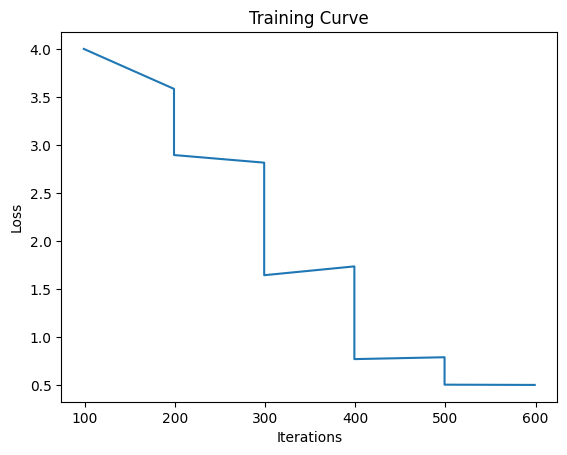

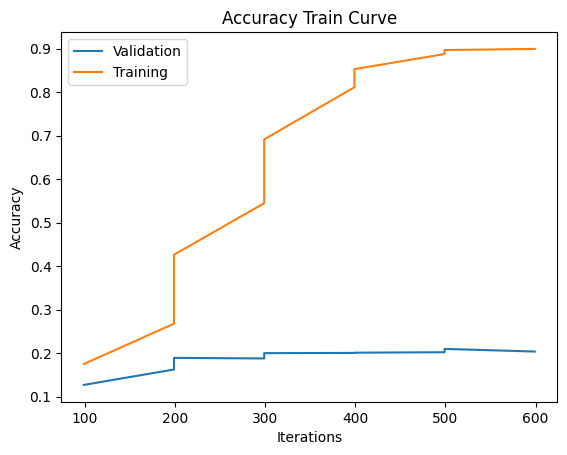

Final Training Accuracy: 0.8996293775054837
Final Validation Accuracy: 0.20360074132909717


In [ ]:
modelepoch2 = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  modelepoch2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(modelepoch2, num_epochs=5, learning_rate=0.001)

Num_epochs: 1

In [ ]:
modelepoch3 = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  modelepoch3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(modelepoch3, num_epochs=1, learning_rate=0.001)

CUDA is not available.  Training on CPU ...


# Tuning Learning Rate

Learning Rate: 0.1

CUDA is available!  Training on GPU ...
Epoch 1, Minibatch 100, Loss: 220.719
	Time Elapsed:  125.19 s 
Epoch 1, Minibatch 200, Loss: 4.462
	Time Elapsed:  249.61 s 
Epoch 2, Minibatch 100, Loss: 4.464
	Time Elapsed:  375.16 s 
Epoch 2, Minibatch 200, Loss: 4.462
	Time Elapsed:  498.74 s 
Epoch 3, Minibatch 100, Loss: 4.468
	Time Elapsed:  624.14 s 
Epoch 3, Minibatch 200, Loss: 4.464
	Time Elapsed:  749.28 s 
Epoch 4, Minibatch 100, Loss: 4.459
	Time Elapsed:  875.41 s 
Epoch 4, Minibatch 200, Loss: 4.468
	Time Elapsed:  998.56 s 
Epoch 5, Minibatch 100, Loss: 4.461
	Time Elapsed:  1123.39 s 
Epoch 5, Minibatch 200, Loss: 4.463
	Time Elapsed:  1246.34 s 
[99, 199, 199, 299, 299, 399, 399, 499, 499, 599]
[220.71869701385498, 4.461743721961975, 4.464144034385681, 4.462138118743897, 4.467616009712219, 4.463553895950318, 4.459212188720703, 4.468352007865906, 4.461190533638001, 4.46299674987793]


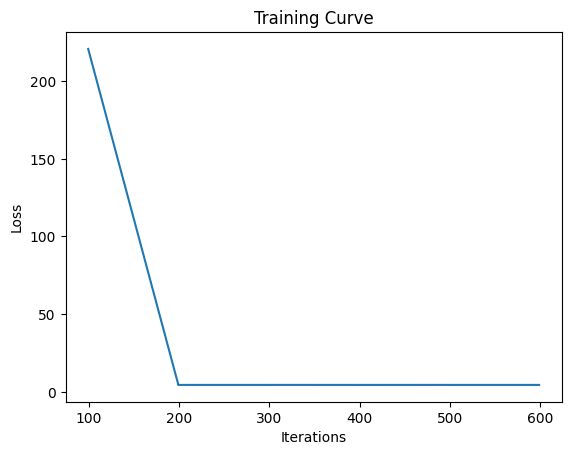

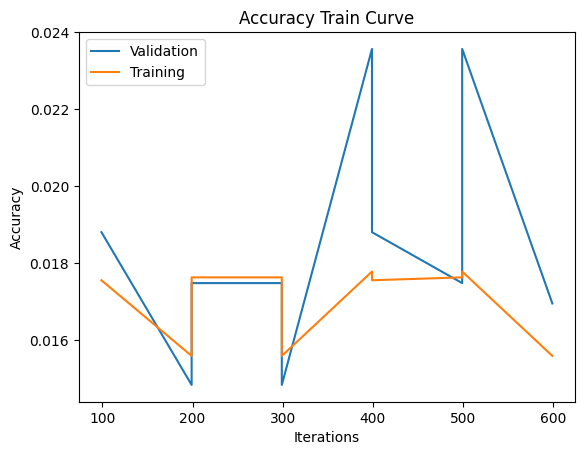

Final Training Accuracy: 0.01558127221844036
Final Validation Accuracy: 0.016944665078104316


In [ ]:
model_lr = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_lr.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(model_lr, num_epochs=5, learning_rate=0.1)

Learning Rate: 0.01

CUDA is available!  Training on GPU ...
Epoch 1, Minibatch 100, Loss: 4.573
	Time Elapsed:  124.83 s 
Epoch 1, Minibatch 200, Loss: 4.443
	Time Elapsed:  248.37 s 
Epoch 2, Minibatch 100, Loss: 4.442
	Time Elapsed:  373.78 s 
Epoch 2, Minibatch 200, Loss: 4.440
	Time Elapsed:  497.30 s 
Epoch 3, Minibatch 100, Loss: 4.441
	Time Elapsed:  623.58 s 
Epoch 3, Minibatch 200, Loss: 4.440
	Time Elapsed:  747.35 s 
Epoch 4, Minibatch 100, Loss: 4.438
	Time Elapsed:  872.57 s 
Epoch 4, Minibatch 200, Loss: 4.442
	Time Elapsed:  995.52 s 
Epoch 5, Minibatch 100, Loss: 4.436
	Time Elapsed:  1122.33 s 
Epoch 5, Minibatch 200, Loss: 4.443
	Time Elapsed:  1246.37 s 
[99, 199, 199, 299, 299, 399, 399, 499, 499, 599]
[4.573086500167847, 4.443209466934204, 4.442445921897888, 4.440120100975037, 4.441149826049805, 4.440187215805054, 4.437950601577759, 4.4417621040344235, 4.436039643287659, 4.442679352760315]


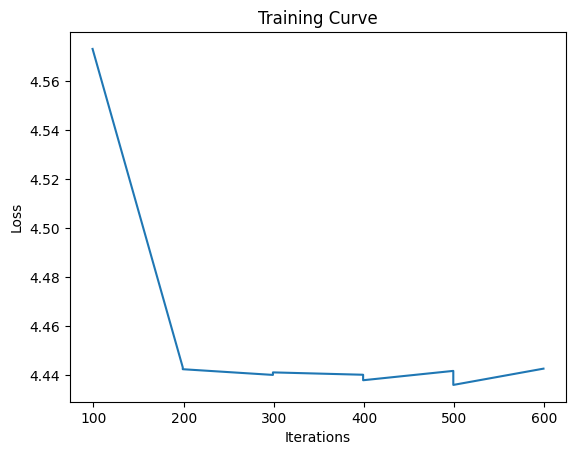

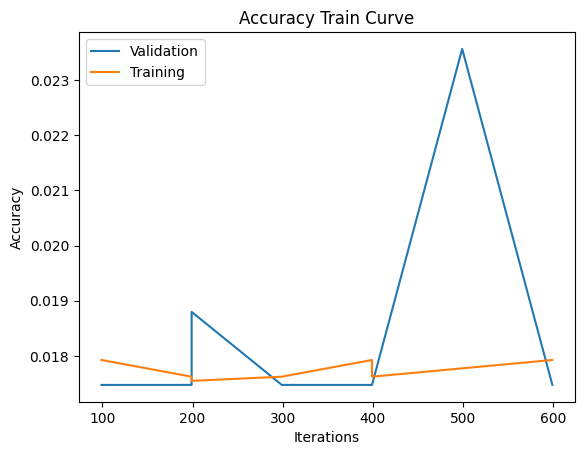

Final Training Accuracy: 0.0179260267755843
Final Validation Accuracy: 0.017474185861795076


In [ ]:
model_lr2 = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_lr2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(model_lr2, num_epochs=5, learning_rate=0.01)

Learning Rate: 0.001

CUDA is not available.  Training on CPU ...
Epoch 1, Minibatch 100, Loss: 4.046
	Time Elapsed:  420.74 s 
Epoch 1, Minibatch 200, Loss: 3.602
	Time Elapsed:  841.90 s 
Epoch 2, Minibatch 100, Loss: 2.981
	Time Elapsed:  1285.59 s 
Epoch 2, Minibatch 200, Loss: 2.941
	Time Elapsed:  1708.79 s 
Epoch 3, Minibatch 100, Loss: 1.822
	Time Elapsed:  2136.28 s 
Epoch 3, Minibatch 200, Loss: 1.892
	Time Elapsed:  2560.38 s 
Epoch 4, Minibatch 100, Loss: 0.850
	Time Elapsed:  2995.33 s 
Epoch 4, Minibatch 200, Loss: 0.866
	Time Elapsed:  3425.55 s 
Epoch 5, Minibatch 100, Loss: 0.519
	Time Elapsed:  3863.57 s 
Epoch 5, Minibatch 200, Loss: 0.548
	Time Elapsed:  4290.12 s 
[99, 199, 199, 299, 299, 399, 399, 499, 499, 599]
[4.045693318843842, 3.6015604281425477, 2.9809704041481018, 2.9409430694580077, 1.8217780077457428, 1.891551694869995, 0.8495597618818284, 0.8663694867491722, 0.5186020417511463, 0.5484214681386947]


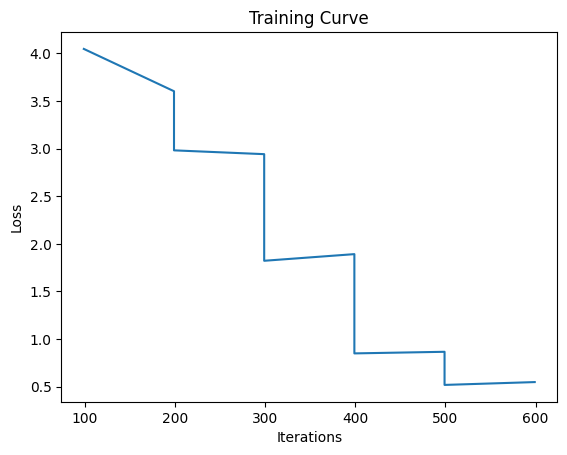

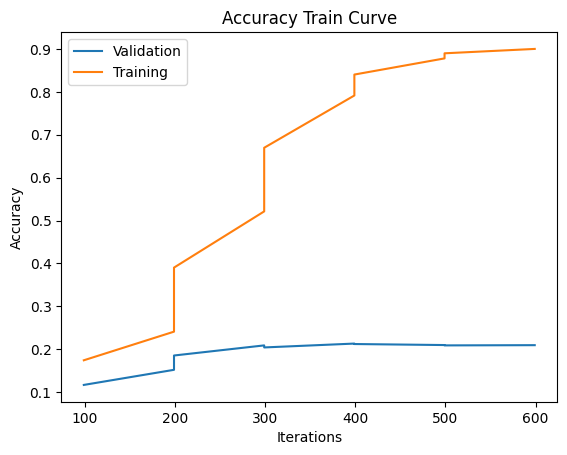

Final Training Accuracy: 0.899931926480599
Final Validation Accuracy: 0.20942546994969552


In [ ]:
model_lr3 = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_lr3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(model_lr3, num_epochs=5, learning_rate=0.001)

# Tuning Batch Size

Batch Size: 32

In [ ]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA is not available.  Training on CPU ...
Epoch 1, Minibatch 100, Loss: 5.052
	Time Elapsed:  279.69 s 
Epoch 1, Minibatch 200, Loss: 4.446
	Time Elapsed:  549.41 s 
Epoch 1, Minibatch 300, Loss: 4.439
	Time Elapsed:  818.74 s 
Epoch 1, Minibatch 400, Loss: 4.445
	Time Elapsed:  1087.37 s 
[99, 199, 299, 399]
[5.052028923034668, 4.445847330093383, 4.4389628887176515, 4.445453433990479]


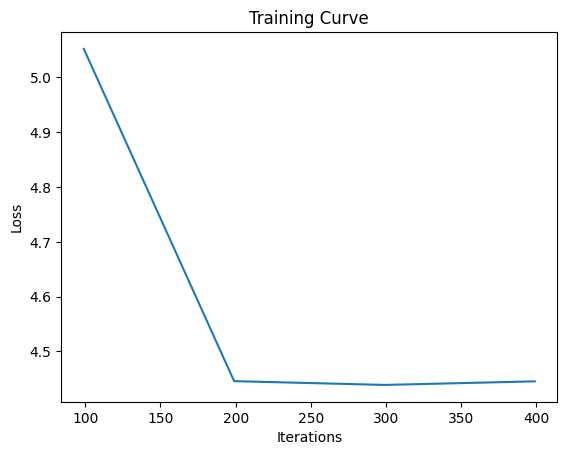

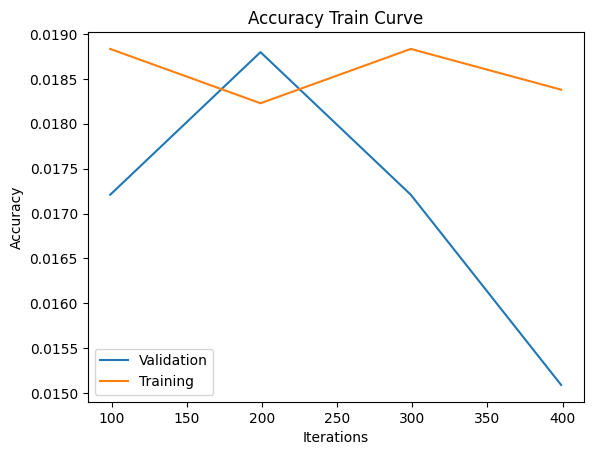

Final Training Accuracy: 0.018379850238257316
Final Validation Accuracy: 0.015091342335186657


In [ ]:
model_batchsize = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_batchsize.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(model_batchsize, num_epochs=1, learning_rate=0.01)

Batch Size: 64

In [ ]:
# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA is not available.  Training on CPU ...
Epoch 1, Minibatch 100, Loss: 4.949
	Time Elapsed:  387.77 s 
Epoch 1, Minibatch 200, Loss: 4.443
	Time Elapsed:  781.20 s 
[99, 199]
[4.949351644515991, 4.443336710929871]


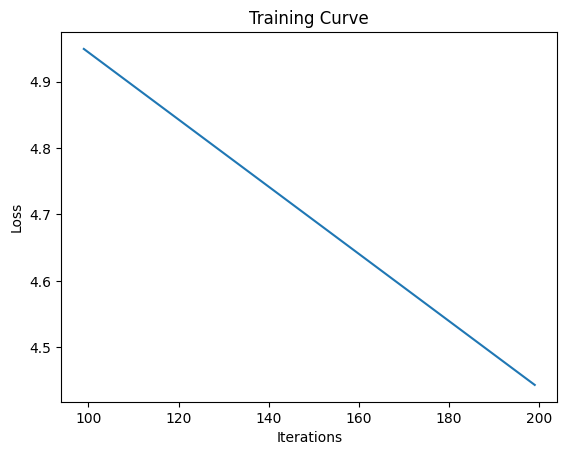

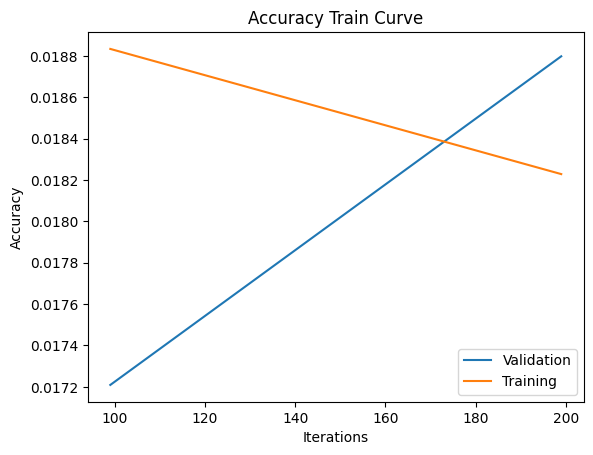

Final Training Accuracy: 0.018228575750699645
Final Validation Accuracy: 0.018797987821021975


In [ ]:
model_batchsize2 = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_batchsize2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(model_batchsize2, num_epochs=1, learning_rate=0.01)

Batch Size: 128

In [ ]:
# Define batch size
batch_size = 128

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA is not available.  Training on CPU ...
Epoch 1, Minibatch 100, Loss: 4.849
	Time Elapsed:  565.43 s 
[99]
[4.849487161636352]


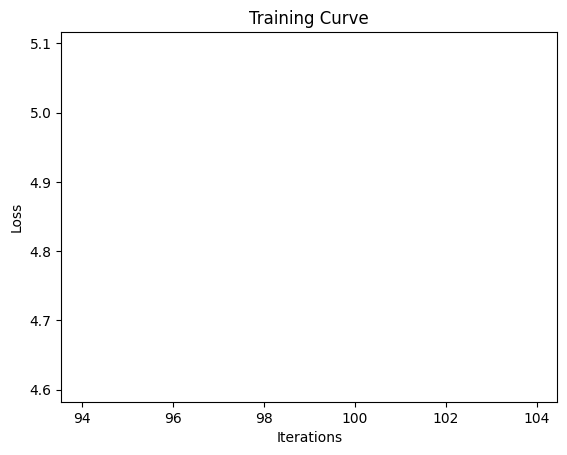

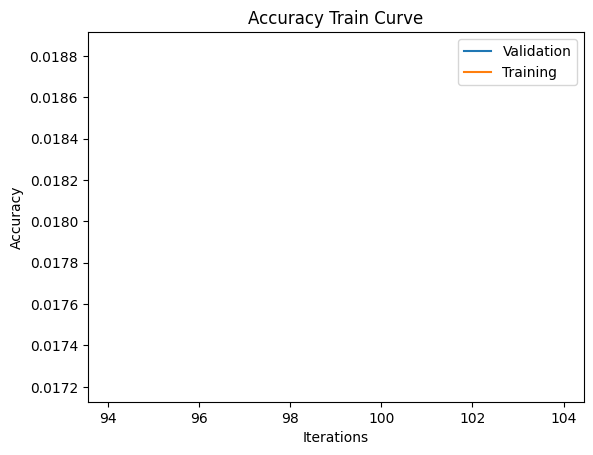

Final Training Accuracy: 0.018833673700930337
Final Validation Accuracy: 0.017209425469949694


In [ ]:
model_batchsize3 = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_batchsize3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(model_batchsize3, num_epochs=1, learning_rate=0.01)